Starting Bitcoin Trading Strategy Analysis...
Saving results to 'results\BTC_trading_resultsFinal.xlsx'...
Trading signals saved to results\BTC_trading_resultsFinal.xlsx

Budget Allocation:
Total Budget: $10,000.00
Trading Allocation (90%): $9,000.00
Fixed Deposit (10%): $1,000.00
Fixed Deposit Annual Interest Rate: 4.00%

FINAL PORTFOLIO VALUE: $1,396,522.69

Trading Performance:
Starting Budget: $10,000.00
Final Portfolio Value: $1,396,522.69
Total Return: 13865.23%
Buy & Hold Return: 855.91%
Maximum Drawdown: -37.98%
Fixed Deposit Final Value: $1,181.85
Total Buy Signals: 80
Total Sell Signals: 80


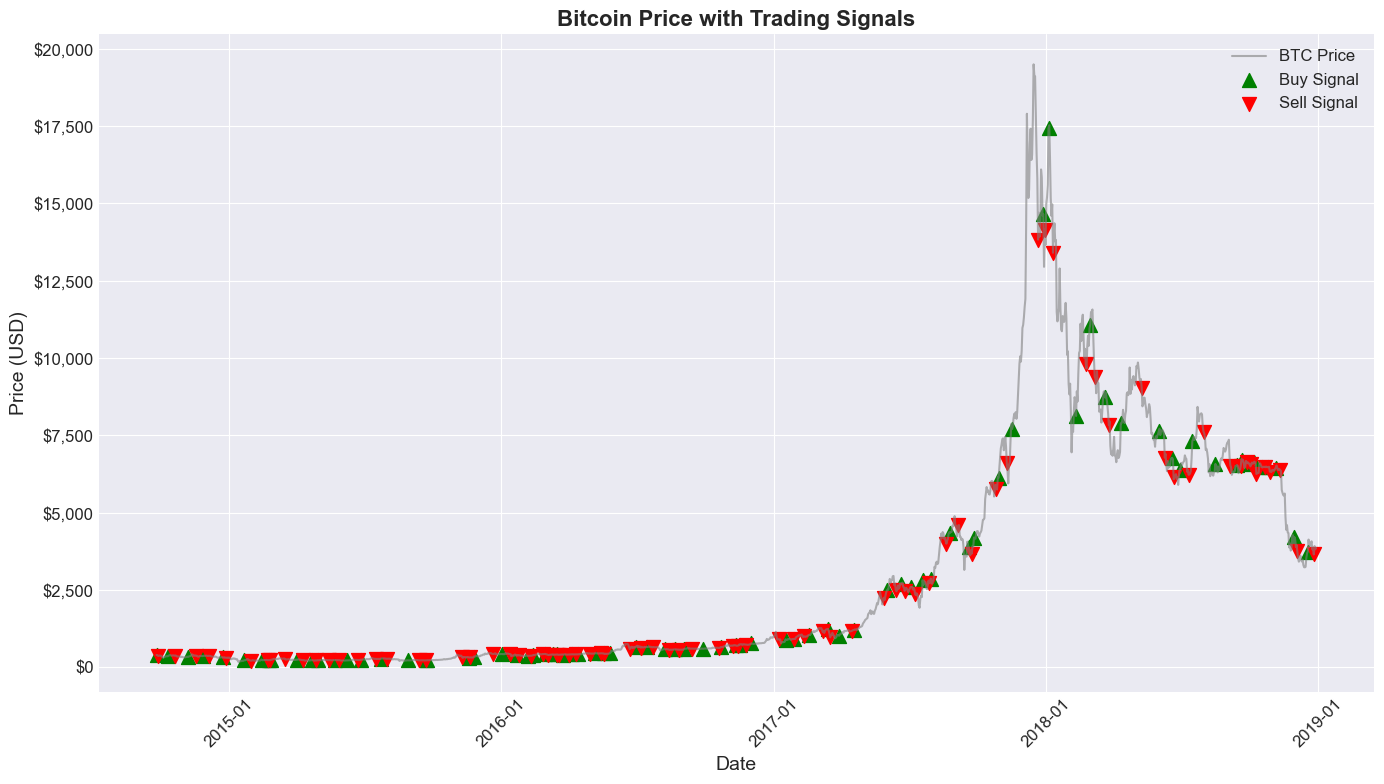

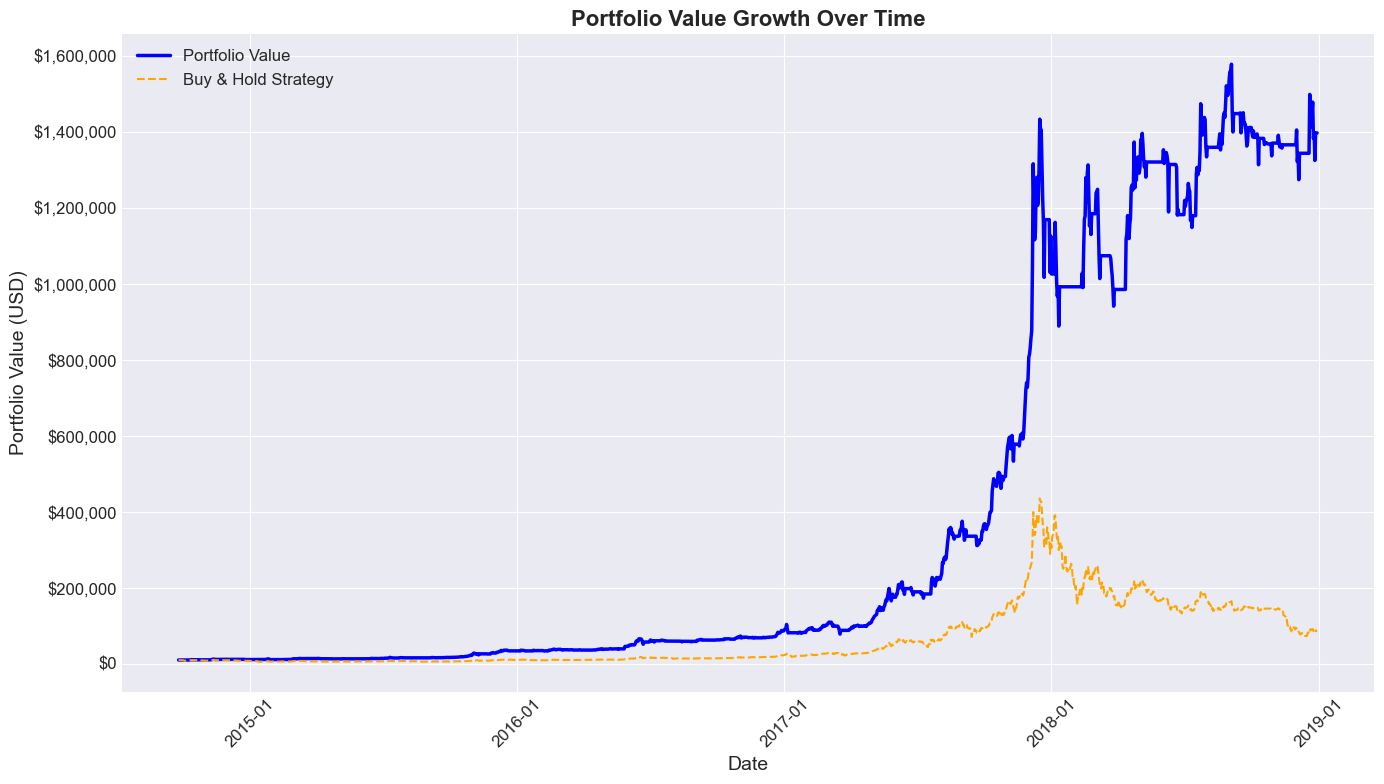

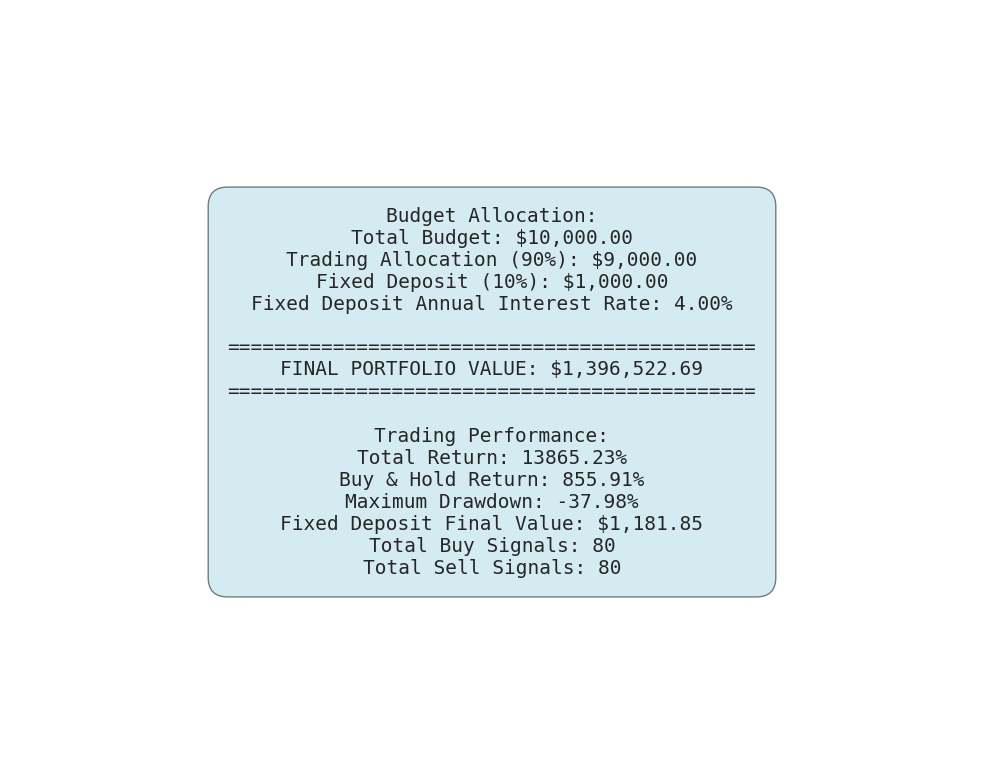


Analysis complete!


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
import warnings
import os
from datetime import datetime
warnings.filterwarnings('ignore')

# Define file paths
INPUT_FILE = 'BTC-USD_train.xlsx'  # Your historical BTC data without signals
OUTPUT_FILE = 'BTC_trading_resultsFinal.xlsx'  # Will be overwritten with consistent signals
RESULTS_DIR = 'results'
INITIAL_BUDGET = 10000  # Starting budget of $10000
TRADING_BUDGET = INITIAL_BUDGET * 0.9  # 90% for trading
FIXED_DEPOSIT = INITIAL_BUDGET * 0.1  # 10% for fixed deposit
FIXED_DEPOSIT_RATE = 0.04  # 4% annual interest rate

# Create results directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load Bitcoin Data
def load_bitcoin_data(file_path):
    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    return df

# Generate trading signals based on strategy
def generate_signals(df):
    # Calculate indicators
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    
    # Drop rows with NaN values from the indicators
    df.dropna(inplace=True)
    
    # Generate Buy/Sell signals
    df['Buy'] = 0
    df['Sell'] = 0
    
    # Simple strategy: Buy when SMA5 crosses above SMA10, Sell when SMA5 crosses below SMA10
    for i in range(1, len(df)):
        # Buy signal: SMA5 crosses above SMA10
        if df['SMA_5'].iloc[i-1] <= df['SMA_10'].iloc[i-1] and df['SMA_5'].iloc[i] > df['SMA_10'].iloc[i]:
            df['Buy'].iloc[i] = 1
        
        # Sell signal: SMA5 crosses below SMA10
        if df['SMA_5'].iloc[i-1] >= df['SMA_10'].iloc[i-1] and df['SMA_5'].iloc[i] < df['SMA_10'].iloc[i]:
            df['Sell'].iloc[i] = 1
    
    return df

# Calculate performance with reinvestment
def calculate_performance(df):
    # Initialize performance tracking
    cash = TRADING_BUDGET
    btc_holdings = 0
    in_position = False
    
    # For tracking portfolio value over time
    portfolio_values = []
    highest_value = INITIAL_BUDGET
    max_drawdown = 0
    
    # For tracking trades
    trades = []
    buy_count = 0
    sell_count = 0
    
    # Calculate fixed deposit growth
    start_date = df['Date'].iloc[0]
    end_date = df['Date'].iloc[-1]
    years_diff = (end_date - start_date).days / 365.25
    fixed_deposit_value = FIXED_DEPOSIT * (1 + FIXED_DEPOSIT_RATE) ** years_diff
    
    # Calculate buy and hold return
    first_price = df['Close'].iloc[0]
    last_price = df['Close'].iloc[-1]
    buy_hold_return = ((last_price / first_price) - 1) * 100
    
    # Process each day
    for i, row in df.iterrows():
        date = row['Date']
        close_price = row['Close']
        open_price = row['Open']
        
        # Calculate current portfolio value
        btc_value = btc_holdings * close_price
        current_value = cash + btc_value
        
        # Track portfolio value
        portfolio_values.append({
            'Date': date,
            'Cash': cash,
            'BTC_Holdings': btc_holdings,
            'BTC_Price': close_price,
            'Portfolio_Value': current_value + fixed_deposit_value
        })
        
        # Update maximum drawdown
        if current_value + fixed_deposit_value > highest_value:
            highest_value = current_value + fixed_deposit_value
        else:
            drawdown = (highest_value - (current_value + fixed_deposit_value)) / highest_value * 100
            max_drawdown = max(max_drawdown, drawdown)
        
        # Process buy signal
        if row['Buy'] == 1 and not in_position and cash > 0:
            buy_count += 1
            btc_holdings = cash / open_price
            trades.append({
                'Date': date,
                'Type': 'BUY',
                'Price': open_price,
                'Amount': cash,
                'BTC': btc_holdings
            })
            cash = 0
            in_position = True
        
        # Process sell signal
        elif row['Sell'] == 1 and in_position and btc_holdings > 0:
            sell_count += 1
            cash = btc_holdings * open_price
            trades.append({
                'Date': date,
                'Type': 'SELL',
                'Price': open_price,
                'Amount': cash,
                'BTC': btc_holdings
            })
            btc_holdings = 0
            in_position = False
    
    # Calculate final portfolio value
    final_btc_value = btc_holdings * last_price
    final_portfolio_value = cash + final_btc_value + fixed_deposit_value
    total_return = ((final_portfolio_value / INITIAL_BUDGET) - 1) * 100
    
    # Create performance summary
    performance_summary = {
        'Initial_Budget': INITIAL_BUDGET,
        'Final_Portfolio_Value': final_portfolio_value,
        'Total_Return_Pct': total_return,
        'Buy_Hold_Return_Pct': buy_hold_return,
        'Max_Drawdown_Pct': max_drawdown,
        'Fixed_Deposit_Value': fixed_deposit_value,
        'Buy_Signals': buy_count,
        'Sell_Signals': sell_count,
        'Final_Cash': cash,
        'Final_BTC_Holdings': btc_holdings,
        'Final_BTC_Value': final_btc_value
    }
    
    # Convert to DataFrames
    portfolio_df = pd.DataFrame(portfolio_values)
    trades_df = pd.DataFrame(trades)
    summary_df = pd.DataFrame([performance_summary])
    
    return portfolio_df, trades_df, summary_df

# Save updated trading results to Excel
def save_results_to_excel(df, filename=OUTPUT_FILE):
    output_path = os.path.join(RESULTS_DIR, filename)
    output_df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Buy', 'Sell']].copy()
    output_df.to_excel(output_path, index=False)
    print(f"Saving results to '{output_path}'...")
    print(f"Trading signals saved to {output_path}")
    return output_path

# Print performance summary in the desired format
def print_performance_summary(summary_df):
    summary = summary_df.iloc[0]
    
    print("\nBudget Allocation:")
    print(f"Total Budget: ${INITIAL_BUDGET:,.2f}")
    print(f"Trading Allocation (90%): ${TRADING_BUDGET:,.2f}")
    print(f"Fixed Deposit (10%): ${FIXED_DEPOSIT:,.2f}")
    print(f"Fixed Deposit Annual Interest Rate: {FIXED_DEPOSIT_RATE*100:.2f}%")
    
    print("\n" + "=" * 45)
    print(f"FINAL PORTFOLIO VALUE: ${summary['Final_Portfolio_Value']:,.2f}")
    print("=" * 45)
    
    print(f"\nTrading Performance:")
    print(f"Starting Budget: ${INITIAL_BUDGET:,.2f}")
    print(f"Final Portfolio Value: ${summary['Final_Portfolio_Value']:,.2f}")
    print(f"Total Return: {summary['Total_Return_Pct']:.2f}%")
    print(f"Buy & Hold Return: {summary['Buy_Hold_Return_Pct']:.2f}%")
    print(f"Maximum Drawdown: -{summary['Max_Drawdown_Pct']:.2f}%")
    print(f"Fixed Deposit Final Value: ${summary['Fixed_Deposit_Value']:,.2f}")
    print(f"Total Buy Signals: {int(summary['Buy_Signals'])}")
    print(f"Total Sell Signals: {int(summary['Sell_Signals'])}")
    
# Create visualizations
def create_visualizations(signals_df, portfolio_df, trades_df, summary_df):
    # Set up the plotting style
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = (14, 8)
    plt.rcParams['font.size'] = 12
    
    # 1. Price Chart with Buy/Sell Signals
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot Bitcoin price
    ax.plot(signals_df['Date'], signals_df['Close'], color='gray', alpha=0.6, linewidth=1.5, label='BTC Price')
    
    # Extract buy and sell signals
    buy_signals = signals_df[signals_df['Buy'] == 1]
    sell_signals = signals_df[signals_df['Sell'] == 1]
    
    # Plot buy signals as green triangles
    ax.scatter(buy_signals['Date'], buy_signals['Close'], color='green', s=100, marker='^', label='Buy Signal')
    
    # Plot sell signals as red triangles
    ax.scatter(sell_signals['Date'], sell_signals['Close'], color='red', s=100, marker='v', label='Sell Signal')
    
    # Set title and labels
    ax.set_title('Bitcoin Price with Trading Signals', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Price (USD)', fontsize=14)
    
    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis to show dollar amounts
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'btc_trading_signals.png'), dpi=300)
    plt.show()
    
    # 2. Portfolio Growth Chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot portfolio value over time
    ax.plot(portfolio_df['Date'], portfolio_df['Portfolio_Value'], color='blue', linewidth=2.5, label='Portfolio Value')
    
    # Add buy and hold reference line
    initial_btc_price = portfolio_df['BTC_Price'].iloc[0]
    buy_hold_values = TRADING_BUDGET * (portfolio_df['BTC_Price'] / initial_btc_price) + FIXED_DEPOSIT
    ax.plot(portfolio_df['Date'], buy_hold_values, color='orange', linestyle='--', linewidth=1.5, label='Buy & Hold Strategy')
    
    # Set title and labels
    ax.set_title('Portfolio Value Growth Over Time', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Portfolio Value (USD)', fontsize=14)
    
    # Format the x-axis to show dates nicely
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Format y-axis to show dollar amounts
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'portfolio_growth.png'), dpi=300)
    plt.show()
    
    # 3. Final Results Summary Visualization
    summary = summary_df.iloc[0]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.axis('off')  # Turn off the axis
    
    # Create a stylized text box
    props = dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.5)
    
    # Text content
    textstr = "Budget Allocation:\n"
    textstr += f"Total Budget: ${INITIAL_BUDGET:,.2f}\n"
    textstr += f"Trading Allocation (90%): ${TRADING_BUDGET:,.2f}\n"
    textstr += f"Fixed Deposit (10%): ${FIXED_DEPOSIT:,.2f}\n"
    textstr += f"Fixed Deposit Annual Interest Rate: {FIXED_DEPOSIT_RATE*100:.2f}%\n\n"
    textstr += "=" * 45 + "\n"
    textstr += f"FINAL PORTFOLIO VALUE: ${summary['Final_Portfolio_Value']:,.2f}\n"
    textstr += "=" * 45 + "\n\n"
    textstr += f"Trading Performance:\n"
    textstr += f"Total Return: {summary['Total_Return_Pct']:.2f}%\n"
    textstr += f"Buy & Hold Return: {summary['Buy_Hold_Return_Pct']:.2f}%\n"
    textstr += f"Maximum Drawdown: -{summary['Max_Drawdown_Pct']:.2f}%\n"
    textstr += f"Fixed Deposit Final Value: ${summary['Fixed_Deposit_Value']:,.2f}\n"
    textstr += f"Total Buy Signals: {int(summary['Buy_Signals'])}\n"
    textstr += f"Total Sell Signals: {int(summary['Sell_Signals'])}"
    
    # Place the text box
    ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='center', horizontalalignment='center', bbox=props, family='monospace')
    
    # Show the final results visualization
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'final_results.png'), dpi=300, bbox_inches='tight')
    plt.show()


# Main function to run everything
def main():
    print("Starting Bitcoin Trading Strategy Analysis...")
    
    # Load data
    signals_df = load_bitcoin_data(INPUT_FILE)
    
    # Generate signals
    signals_df = generate_signals(signals_df)
    
    # Save the signals to Excel (this will now have consistent signals)
    save_results_to_excel(signals_df)
    
    # Calculate performance
    portfolio_df, trades_df, summary_df = calculate_performance(signals_df)
    
    # Print performance summary
    print_performance_summary(summary_df)
    
    # Create visualizations
    create_visualizations(signals_df, portfolio_df, trades_df, summary_df)
    

    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()